<a href="https://colab.research.google.com/github/pranavrelds/Sentiment-analysis-quora-insincere-question-classification/blob/main/Quora_Insincere_Questions_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [68]:
import operator 
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from gensim.models import KeyedVectors
from keras.initializers import Constant
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Model,load_model,Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Dense, Input, LSTM, Dropout, Activation, Conv1D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report,f1_score

# Configurations

In [38]:
DIR = '/content/drive/MyDrive/Quora Insincere Questions Classification/'
GOOGLE_VECTOR = '/content/drive/MyDrive/Quora Insincere Questions Classification/GoogleNews-vectors-negative300.bin'
EMBEDDING_DIM = 300
EPOCHS = 4
PATIENCE = 2
LEARNING_RATE = 0.001
BEST_MODEL = '/content/drive/MyDrive/Quora Insincere Questions Classification/BEST_MODEL/model.hdf5'


DF_TRAIN = pd.read_csv(DIR+'train.csv')

# Preprocessing

In [14]:
import re
import json
import nltk
import spacy
import string
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


# Feature Engineering

def get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

def get_wordcounts(x):
	length = len(str(x).split())
	return length

def get_avg_wordlength(x):
	count = get_charcounts(x)/get_wordcounts(x)
	return count

def get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

def get_features(df, text_column):
  if type(df) == pd.core.frame.DataFrame:

    df['question_text'] = df[text_column].apply(lambda x: str(x))
    df['char_counts'] = df[text_column].apply(lambda x: get_charcounts(x))
    df['char_length'] =df[text_column].apply(lambda x: len(str(x)))
    df['word_counts'] = df[text_column].apply(lambda x: get_wordcounts(x))
    df['avg_wordlength'] = df[text_column].apply(lambda x: get_avg_wordlength(x))
    df['stopwords_counts'] = df[text_column].apply(lambda x: get_stopwords_counts(x))
    df['digits_counts'] = df[text_column].apply(lambda x: get_digit_counts(x))
    df['uppercase_counts'] = df[text_column].apply(lambda x: get_uppercase_counts(x))
    df['titlewords_count'] = df[text_column].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['unique_words_count'] = df[text_column].apply(lambda x: len(set(str(x).split())))
    df['numbers_count'] = df[text_column].apply(lambda comment: sum(1 for c in comment if c.isdigit()))
    df['punctuations_count'] =df[text_column].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
  
  else:
     print('ERROR: This function takes only Pandas DataFrame')
		
  return df

# Cleaning text

def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

#https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(x):
    if '[math]' in x:
        x = re.sub('\[math\].*?math\]', 'math eqaution', x)
    if 'http' in x or 'www' in x:
        x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x)
    return x

def remove_symbols_and_punctuations(x):
  x = str(x)
  for symbol in symbols_and_punctuations:
    if symbol in x:
      x = x.replace(symbol, ' ')
    return x

def get_spellcorrect(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

def remove_digits(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def remove_abbreviations(x):
	abbreviations = json.load(open('/content/drive/MyDrive/Quora Insincere Questions Classification/abbreviations.json'))

	if type(x) is str:
		for key in abbreviations:
			value = abbreviations[key]
			raw_text = r'\b' + key + r'\b'
			x = re.sub(raw_text, value, x)
		return x
	else:
		return x

def remove_html_tags(x):
	return BeautifulSoup(x, 'lxml').get_text().strip()
 
def remove_multiple_whitespace(x):
  return re.sub(' +', ' ', x)

def remove_non_alphanumeric(x):
  return re.sub('[\W_]+', ' ', x, flags=re.UNICODE)

def get_clean_text(x):
  x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')  
  x = clean_tag(x)
  x = remove_symbols_and_punctuations(x)
  x = get_spellcorrect(x)
  x = remove_stopwords(x)
  x = remove_abbreviations(x)
  return x

def preprocess(x):
  x = remove_multiple_whitespace(x)
  x = remove_symbols_and_punctuations(x)
  x = remove_abbreviations(x)
  x = get_spellcorrect(x)
  x = remove_html_tags(x)
  x = remove_non_alphanumeric(x)
  x = remove_digits(x)
  return x 

lemmatizer = WordNetLemmatizer()
def get_lemmatization(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)
  return x

def get_vocab(df, text_column, verbose =  True):
  sentences = df[text_column].apply(lambda x: x.split()).values
  vocab = {}
  for sentence in tqdm(sentences, disable = (not verbose)):
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1

  return vocab

#https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings?scriptVersionId=7347748&cellId=13
def check_coverage(vocab,embeddings_index):
  # check coverage of embedding vs vocabulary of training data
    a = {}
    # out of vocabulary (oov) 
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

## Symbols and Dict

In [13]:
#https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 
symbols_and_punctuations = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢','∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', 
        'é', '&amp;','₹', 'á', '²', 'ế', '청', '하', '¨', '‘', '√', '\xa0', '高', '端', '大', '气', '上', '档', '次', '_', '½', 'π', '#', 
        '小', '鹿', '乱', '撞', '成', '语', 'ë', 'à', 'ç', '@', 'ü', 'č', 'ć', 'ž', 'đ', '°', 'द', 'े', 'श', '्', 'र', 'ो', 'ह', 
        'ि', 'प', 'स', 'थ', 'त', 'न', 'व', 'ा', 'ल', 'ं', '林', '彪', '€', '\u200b', '˚', 'ö', '~', '—', '越', '人', 'च', 'म', 'क', 
        'ु', 'य', 'ी', 'ê', 'ă', 'ễ', '∞', '抗', '日', '神', '剧', '，', '\uf02d', '–', 'ご', 'め', 'な', 'さ', 'い', 'す', 
        'み', 'ま', 'せ', 'ん', 'ó', 'è', '£', '¡', 'ś', '≤', '¿', 'λ', '魔', '法', '师', '）', 'ğ', 'ñ', 'ř', '그', '자', '식', '멀', 
        '쩡', '다', '인', '공', '호', '흡', '데', '혀', '밀', '어', '넣', '는', '거', '보', '니', 'ǒ', 'ú', '️', 'ش', 'ه', 'ا', 'د',
        'ة', 'ل', 'ت', 'َ', 'ع', 'م', 'ّ', 'ق', 'ِ', 'ف', 'ي', 'ب', 'ح', 'ْ', 'ث', '³', '饭', '可', '以', '吃', '话', '不', '讲', 
        '∈', 'ℝ', '爾', '汝', '文', '言', '∀', '禮', 'इ', 'ब', 'छ', 'ड', '़', 'ʒ', '有', '「', '寧', '錯', '殺', '一', '千', '絕', 
        '放', '過', '」', '之', '勢', '㏒', '㏑', 'ू', 'â', 'ω', 'ą', 'ō', '精', '杯', 'í', '生', '懸', '命', 'ਨ', 'ਾ', 'ਮ', 'ੁ', 
        '₁', '₂', 'ϵ', 'ä', 'к', 'ɾ', '\ufeff', 'ã', '©', '\x9d', 'ū', '™', '＝', 'ù', 'ɪ', 'ŋ', 'خ', 'ر', 'س', 'ن', 'ḵ', 'ā',
        'σ', '≡', '¹', '⊆', 'ı', '∆', 'μ', '卐', '¿', '∑', '≥', 'å', 'x₁','∆g','ⁿ','∘','▾','ψ', 'का', 'एक', 'को', 'लगाना', 'ß']

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
                "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling',
                'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize',
                'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist',
                'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency'
               }

# Word Embeddings and Classification with Deep Learning

In [16]:
#Preprocess text data by removing, multiple white spaces, non-aplhanumeric characters, symbols etc
DF_PREPROCESSING['clean_question_text'] = DF_PREPROCESSING['question_text'].apply(lambda x :preprocess(x))

In [18]:
# Checkpoint 
# DF_PREPROCESSING.to_csv(DIR+'df_preprocess_embedding.csv', index=False)

In [19]:
# Create vocabulary of the preprocessed data
vocab = get_vocab(DF_PREPROCESSING , 'clean_question_text')

In [20]:
# Reading the pretrained model for Word2Vec Embedder
emebedding = GOOGLE_VECTOR
embeddings_index = KeyedVectors.load_word2vec_format(emebedding, binary=True)

In [22]:
# Check coverage of vocaublary in the embedding
coverage = check_coverage(vocab,embeddings_index)


Found embeddings for 63.69% of vocab
Found embeddings for  90.89% of all text


In [23]:
def get_tokenize_encode_pad(text,max_length):
  # create tokens
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)
  # Transform each word in text to a sequence of integers
  encoded_text = tokenizer.texts_to_sequences(text)
  # paddind the sequence to same length.
  X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
  return X, tokenizer

In [24]:
# max_lenth = 80 as seen in the EDA(word_counts)
max_length = 80
X, tokenizer = get_tokenize_encode_pad(DF_PREPROCESSING['clean_question_text'], max_length=max_length)

In [47]:
X_data, X_test, y_data, y_test = train_test_split(X, DF_PREPROCESSING['target'], test_size=0.2, random_state=0, stratify=DF_PREPROCESSING['target'])
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)
print('Number of questions in training set : ', X_train.shape[0])
print('Number of questions in test set : ', X_test.shape[0])
print('Number of questions in validation set : ', X_val.shape[0])

Number of questions in training set :  835917
Number of questions in test set :  261225
Number of questions in validation set :  208980


In [48]:
# Defining the embedding matrix here, where all the words which are not in the pretrained embedding
# being assigned a zero vector

vocab_length =  len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_length, EMBEDDING_DIM))

out_of_vocab_count = 0

for word, index in tqdm(tokenizer.word_index.items()):
  try:
    embedding_vector = embeddings_index.get_vector(word)

    embedding_matrix[index] = embedding_vector
  except (KeyError):
    out_of_vocab_count += 1
    continue   
print('Total out of vocab words: ', out_of_vocab_count)


Total out of vocab words:  108142


In [49]:
# Defining the embedding layer with pre trained word embeddings. 
# The embedding layer maps the words to their embedding vectors from the embedding matrix.

embedding_layer = Embedding(input_dim = vocab_length,
                            output_dim = EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False) # Trainable to false to use Google embedding

In [50]:
def get_model (max_length):

    input = Input(shape=(max_length,))

    x = (embedding_layer)(input)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    x = Conv1D(64,3,activation="relu")(x)

    x = GlobalMaxPool1D()(x)

    x = Dense(128, activation="relu")(x)

    x = Dropout(0.2)(x)

    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=input, outputs=output)
    
    model.summary()
    return model

In [51]:
model = get_model(max_length= 80)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           55442100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 256)           439296    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 64)            49216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

In [52]:
# Reduce the learning rate when the model is not improving
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         factor=0.2,
                                         patience=2,
                                         verbose=1,
                                         mode= 'auto'
                                         )

earlystopping= EarlyStopping(monitor="val_accuracy",
                             patience=PATIENCE,
                             mode= 'max',
                             restore_best_weights=True
                             )

checkpointer = ModelCheckpoint(filepath = BEST_MODEL,
                               monitor = 'val_accuracy', 
                               verbose = 1, 
                               save_best_only = True,
                               mode = 'max'
                               )
callbacks = [reduce_learning_rate, earlystopping, checkpointer]

In [54]:
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate = LEARNING_RATE), 
              metrics=['accuracy'])

In [55]:
history = model.fit(X_train,
                  y_train,
                  batch_size=512,
                  epochs=EPOCHS,
                  validation_data=(X_val, y_val),
                  callbacks=[callbacks])

Epoch 1/4
1633/1633 [==============================] - 86s 50ms/step - loss: 0.1459 - accuracy: 0.9457 - val_loss: 0.1129 - val_accuracy: 0.9560

Epoch 00001: val_accuracy improved from -inf to 0.95603, saving model to /content/drive/MyDrive/Quora Insincere Questions Classification/BEST_MODEL/model.hdf5
Epoch 2/4
1633/1633 [==============================] - 81s 50ms/step - loss: 0.1083 - accuracy: 0.9573 - val_loss: 0.1079 - val_accuracy: 0.9579

Epoch 00002: val_accuracy improved from 0.95603 to 0.95792, saving model to /content/drive/MyDrive/Quora Insincere Questions Classification/BEST_MODEL/model.hdf5
Epoch 3/4
1633/1633 [==============================] - 81s 50ms/step - loss: 0.1021 - accuracy: 0.9595 - val_loss: 0.1051 - val_accuracy: 0.9588

Epoch 00003: val_accuracy improved from 0.95792 to 0.95876, saving model to /content/drive/MyDrive/Quora Insincere Questions Classification/BEST_MODEL/model.hdf5
Epoch 4/4
1633/1633 [==============================] - 81s 50ms/step - loss: 0.

In [45]:
def get_history_plot(history):
  # summarize history for given metric
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

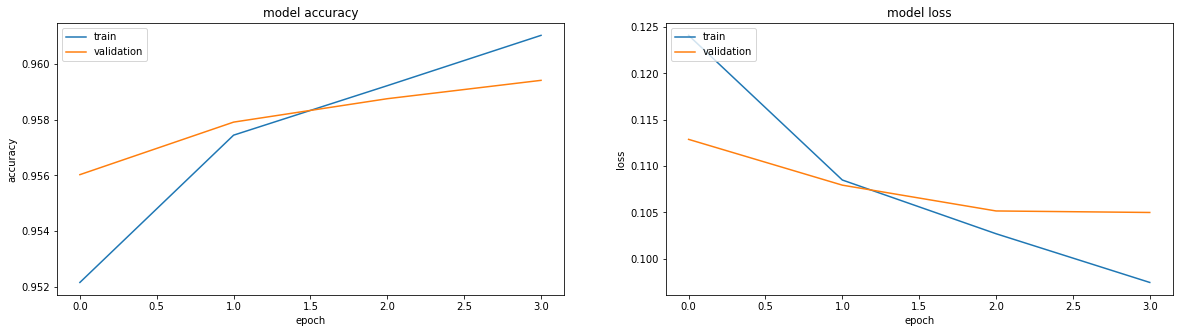

In [56]:
get_history_plot(history)

In [62]:
%time
prediction_val = model.predict(X_val)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [81]:
# Finding threshold
threshold = np.arange(0.1,0.52,0.02)
for t in threshold:
  print('f1-score {0:2.4f} at threshold {1:2.2f}'.format(f1_score(y_val, (prediction_val>t).astype(int)), t))

f1-score 0.6106 at threshold 0.10
f1-score 0.6246 at threshold 0.12
f1-score 0.6353 at threshold 0.14
f1-score 0.6423 at threshold 0.16
f1-score 0.6496 at threshold 0.18
f1-score 0.6550 at threshold 0.20
f1-score 0.6594 at threshold 0.22
f1-score 0.6631 at threshold 0.24
f1-score 0.6660 at threshold 0.26
f1-score 0.6671 at threshold 0.28
f1-score 0.6678 at threshold 0.30
f1-score 0.6689 at threshold 0.32
f1-score 0.6688 at threshold 0.34
f1-score 0.6680 at threshold 0.36
f1-score 0.6667 at threshold 0.38
f1-score 0.6656 at threshold 0.40
f1-score 0.6647 at threshold 0.42
f1-score 0.6617 at threshold 0.44
f1-score 0.6575 at threshold 0.46
f1-score 0.6516 at threshold 0.48
f1-score 0.6465 at threshold 0.50


**Observation :**

threshold of 0.32 gives the highest f1-score

In [82]:
# Getting prediction
%time
prediction = model.predict(X_test, verbose=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
8164/8164 [==============================] - 38s 5ms/step


In [83]:
prediction = [1 if prob >= 0.32 else 0 for prob in prediction]

In [89]:
output = pd.DataFrame (prediction, columns=['prediction'])
output

,prediction
0,0
1,0
2,0
3,1
4,1
...,...
261220,0
261221,0
261222,1
261223,0
